In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    multilabel_confusion_matrix,
    f1_score,
    hamming_loss,
    jaccard_score,
)
from sklearn.model_selection import KFold

### Data & Visualisation

Multi-label classification

1024 instances

10 genese

In [2]:
# We load from pre-processed data

full_data = np.load("/data/public/boolean_networks/fission/fission_raw_data.npy")

### Common code

In [3]:
# Config
NUM_FOLD = 10
RANDOM_STATE = 73

In [4]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [5]:
def binary_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
    print_cm: bool = False,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")

    # K-Fold
    kf = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state,
    )

    fold_hamming_loss = []
    fold_micro_f1 = []
    fold_micro_jaccard = []

    for i, (train_index, test_index) in enumerate(kf.split(np.arange(len(full_data)))):
        train_X = full_data[train_index, 0]
        train_y = full_data[train_index, 1]
        test_X = full_data[test_index, 0]
        test_y = full_data[test_index, 1]

        model.fit(train_X, train_y)

        y_pred = model.predict(test_X)

        hamming_loss_score = hamming_loss(test_y, y_pred)
        micro_f1 = f1_score(test_y, y_pred, average="micro")
        micro_jaccard = jaccard_score(test_y, y_pred, average="micro")

        fold_hamming_loss.append(hamming_loss_score)
        fold_micro_f1.append(micro_f1)
        fold_micro_jaccard.append(micro_jaccard)

        print(
            f"Fold {i}: F1={micro_f1:.4f}, Jaccard={micro_jaccard:.4f}, Hamming={hamming_loss_score:.4f}"
        )

        if print_cm:
            cm = multilabel_confusion_matrix(test_y, y_pred)
            print(cm)


    print("\nCross-Validation Results:")
    print(f"Mean Hamming Loss: {get_fold_print_string(fold_hamming_loss)}")
    print(f"Mean Micro F1: {get_fold_print_string(fold_micro_f1)}")
    print(f"Mean Micro Jaccard: {get_fold_print_string(fold_micro_jaccard)}")


## Random forest

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=72)
binary_classification(model, "Random Forest")

Model Random Forest with 10-fold cross-validation

Fold 0: F1=0.9899, Jaccard=0.9799, Hamming=0.0068
Fold 1: F1=0.9970, Jaccard=0.9939, Hamming=0.0019
Fold 2: F1=0.9953, Jaccard=0.9907, Hamming=0.0029
Fold 3: F1=0.9925, Jaccard=0.9852, Hamming=0.0049
Fold 4: F1=0.9956, Jaccard=0.9912, Hamming=0.0029
Fold 5: F1=0.9863, Jaccard=0.9731, Hamming=0.0088
Fold 6: F1=0.9873, Jaccard=0.9748, Hamming=0.0078
Fold 7: F1=0.9881, Jaccard=0.9765, Hamming=0.0078
Fold 8: F1=0.9881, Jaccard=0.9765, Hamming=0.0078
Fold 9: F1=0.9970, Jaccard=0.9939, Hamming=0.0020

Cross-Validation Results:
Mean Hamming Loss: 0.005 ± 0.001
Mean Micro F1: 0.992 ± 0.001
Mean Micro Jaccard: 0.984 ± 0.003


## Decision tree

In [7]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

In [8]:
model = DecisionTreeClassifier(random_state=74, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
kf = KFold(n_splits=NUM_FOLD, shuffle=True, random_state=RANDOM_STATE)

fold_hamming_loss = []
fold_micro_f1 = []
fold_micro_jaccard = []
tree_stats: list[dict[str, float]] = []

for i, (train_index, test_index) in enumerate(kf.split(np.arange(len(full_data)))):
    train_X = full_data[train_index, 0]
    train_y = full_data[train_index, 1]
    test_X = full_data[test_index, 0]
    test_y = full_data[test_index, 1]
    model.fit(train_X, train_y)

    y_pred = model.predict(test_X)

    hamming_loss_score = hamming_loss(test_y, y_pred)
    micro_f1 = f1_score(test_y, y_pred, average="micro")
    micro_jaccard = jaccard_score(test_y, y_pred, average="micro")

    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    fold_hamming_loss.append(hamming_loss_score)
    fold_micro_f1.append(micro_f1)
    fold_micro_jaccard.append(micro_jaccard)

    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(
        f"Fold {i}: F1={micro_f1:.4f}, Jaccard={micro_jaccard:.4f}, Hamming={hamming_loss_score:.4f}"
    )


print("\nCross-Validation Results:")
print(f"Mean Hamming Loss: {get_fold_print_string(fold_hamming_loss)}")
print(f"Mean Micro F1: {get_fold_print_string(fold_micro_f1)}")
print(f"Mean Micro Jaccard: {get_fold_print_string(fold_micro_jaccard)}")

print("\nTree Stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

Decision tree with 10-fold cross-validation

Fold 0: F1=0.9606, Jaccard=0.9241, Hamming=0.0272
Fold 1: F1=0.9399, Jaccard=0.8867, Hamming=0.0388
Fold 2: F1=0.9545, Jaccard=0.9130, Hamming=0.0291
Fold 3: F1=0.9504, Jaccard=0.9056, Hamming=0.0330
Fold 4: F1=0.9472, Jaccard=0.8997, Hamming=0.0363
Fold 5: F1=0.9615, Jaccard=0.9259, Hamming=0.0255
Fold 6: F1=0.9571, Jaccard=0.9176, Hamming=0.0275
Fold 7: F1=0.9503, Jaccard=0.9053, Hamming=0.0333
Fold 8: F1=0.9636, Jaccard=0.9298, Hamming=0.0245
Fold 9: F1=0.9556, Jaccard=0.9150, Hamming=0.0294

Cross-Validation Results:
Mean Hamming Loss: 0.030 ± 0.001
Mean Micro F1: 0.954 ± 0.002
Mean Micro Jaccard: 0.912 ± 0.004

Tree Stats:
Avg Max Depth: 10.000 ± 0.000
Avg Avg Depth: 9.038 ± 0.018
Avg Branches: 392.500 ± 4.401


[Text(0.5399532935285054, 0.9545454545454546, 'x[9] <= 0.5\ngini = 0.424\nsamples = 922\nvalue = [[1.0, 0.0]\n[0.493, 0.507]\n[0.676, 0.324]\n[0.389, 0.611]\n[0.516, 0.484]\n[0.76, 0.24]\n[0.465, 0.535]\n[0.385, 0.615]\n[0.533, 0.467]\n[0.552, 0.448]]'),
 Text(0.28342883281972264, 0.8636363636363636, 'x[7] <= 0.5\ngini = 0.307\nsamples = 463\nvalue = [[1.0, 0.0]\n[0.509, 0.491]\n[0.269, 0.731]\n[0.717, 0.283]\n[0.285, 0.715]\n[0.572, 0.428]\n[0.679, 0.321]\n[1.0, 0.0]\n[0.32, 0.68]\n[1.0, 0.0]]'),
 Text(0.411691063174114, 0.9090909090909092, 'True  '),
 Text(0.15434803543913714, 0.7727272727272727, 'x[0] <= 0.5\ngini = 0.27\nsamples = 232\nvalue = [[1.0, 0.0]\n[0.518, 0.482]\n[0.288, 0.712]\n[0.555, 0.445]\n[0.294, 0.706]\n[1.0, 0.0]\n[0.679, 0.321]\n[1.0, 0.0]\n[0.328, 0.672]\n[1.0, 0.0]]'),
 Text(0.07612673343605547, 0.6818181818181818, 'x[3] <= 0.5\ngini = 0.216\nsamples = 117\nvalue = [[1.0, 0.0]\n[1.0, 0.0]\n[0.276, 0.724]\n[0.551, 0.449]\n[0.286, 0.714]\n[1.0, 0.0]\n[0.695, 0.305

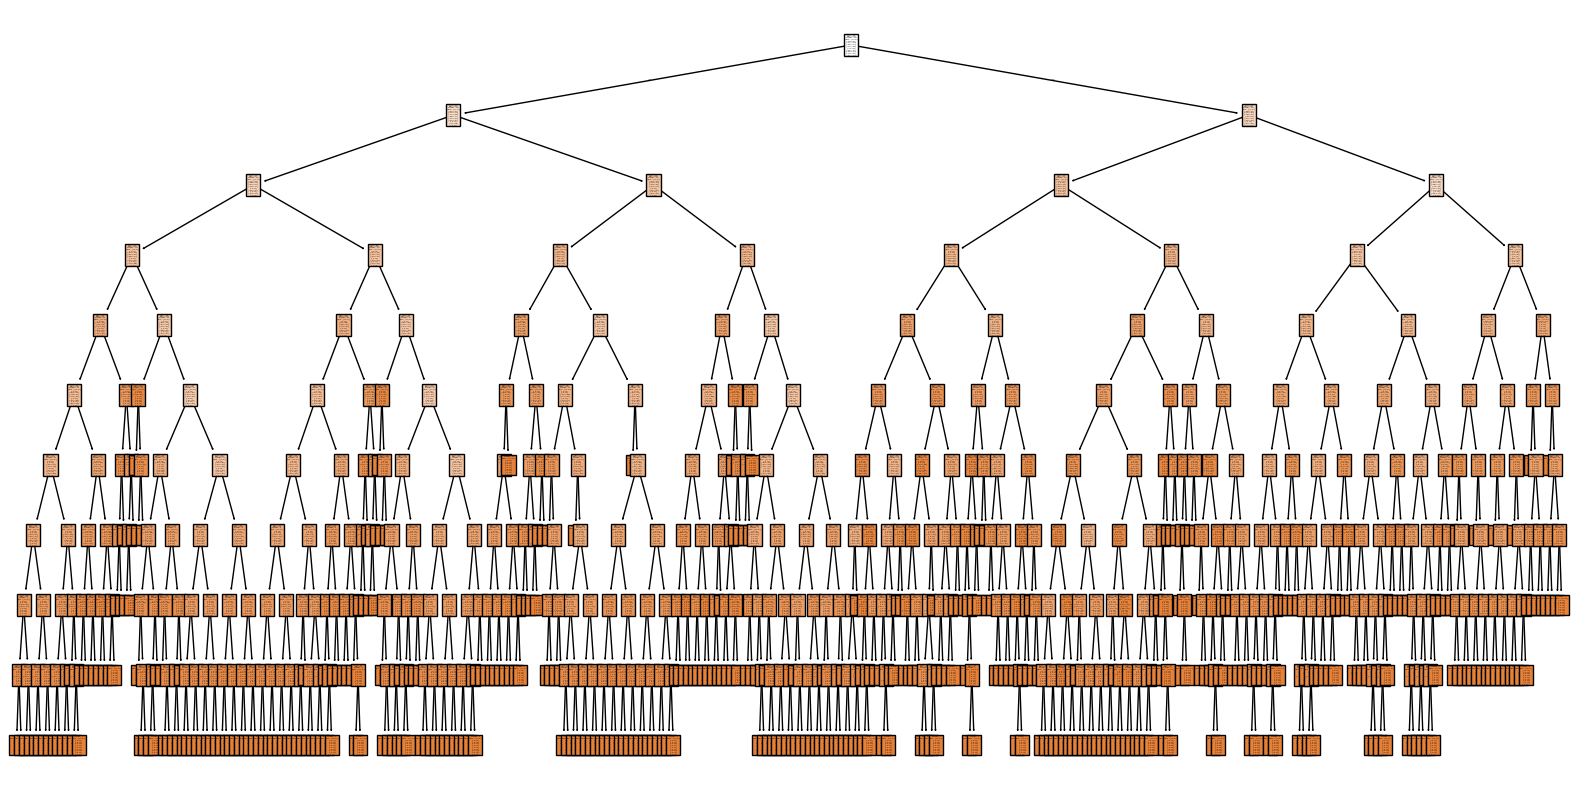

In [9]:
# display the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True)